## Synthesizing data for Indian Art Music predominant pitch extraction

### 1. Introduction

The goal of the code in this notebook is to synthesize Carnatic Music vocal audio data to generate F0 (fundamental frequency) ground-truth for training and evaluating pitch extraction models for Indian Art Music. We use the vocal audio tracks from the [Saraga Carnatic Dataset](https://mtg.github.io/saraga/).

This notebook has been designed to be reproducible from any Google Drive user account, but you must run it using Google Colab. The externals are automatically installed, downloaded and unzipped, and compiled.

**You can see a more complete and advanced version of this code in this repository: [genisplaja/carnatic_melody_synthesis](https://github.com/genisplaja/carnatic_melody_synthesis), in which several additional steps are taken to clean, improve and enhance both synthesized audio and pitch annotations. Also, in this repository, mixed tracks with all the Carnatic instrument line-up are generated.**

#### **Used tools:**
* [mirdata](https://github.com/mir-dataset-loaders/mirdata)
* [Essentia](https://github.com/MTG/essentia) by MTG
* Adapted version of [sms-tools](https://github.com/MTG/sms-tools) by MTG
* [MELODIA](https://www.justinsalamon.com/melody-extraction.html) by Justin Salamon and Emilia Gómez

**Please contact me if you have any problem with this notebook: genis.plaja01@estudiant.upf.edu**

### 2. Setting the environment

Installing and importing all the dependencies needed during the code.

In [ ]:
!pip install gdown

import importlib.util
if importlib.util.find_spec('essentia') is None:
    !pip install essentia

if importlib.util.find_spec('mirdata') is None:
    !pip install mirdata

import gdown
import sys
import os
import mirdata
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import essentia.standard as estd
from scipy.signal import get_window
from scipy.io.wavfile import write
from scipy.ndimage import gaussian_filter1d

import warnings
warnings.filterwarnings("ignore")

Downloading my adapted version of sms_tools software using gdown and links from my own Google Drive account.

In [ ]:
url = 'https://drive.google.com/uc?id=1NaC1ZcgkMVUIIprPZLsMJ3UTxtNwjLvz'
output = 'sms_tools.zip'
gdown.download(url, output, quiet=True)
!unzip /content/sms_tools.zip
if os.path.exists('/content/__MACOSX'):
    !rm -r /content/__MACOSX
!rm /content/sms_tools.zip

Compiling adapted version of sms_tools software.

In [ ]:
# Compile sms-tools modules
!python '/content/sms_tools/models/utilFunctions_C/compileModule.py' build_ext --inplace

### 3. Getting the dataset using mirdata

Downloading and validating the Saraga Carnatic dataset using `mirdata`.

In [ ]:
saraga_carnatic = mirdata.initialize('saraga_carnatic', data_home='/content/')
saraga_carnatic.download()

INFO: Downloading ['all'] to /content/
INFO: [all] downloading saraga1.5_carnatic.zip
13.4GB [38:19, 6.25MB/s]                            


In [ ]:
saraga_carnatic.validate()

100%|██████████| 249/249 [04:58<00:00,  1.20s/it]
INFO: Success: the dataset is complete and all files are valid.
INFO: --------------------


({'tracks': {}}, {'tracks': {}})

We need to first identify the tracks that have vocal channel available, since is the data source we need for a good analysis/synthesis. For that reason, we first list the tracks that have multi-channel vocal data. We can retrieve that information iterating over the Saraga Carnatic tracks.


In [ ]:
saraga_data = saraga_carnatic.load_tracks()
saraga_ids = saraga_carnatic.track_ids

for track_id in saraga_ids:
    if saraga_data[track_id].audio_vocal_path is not None:
        print(track_id)

0_Dorakuna
1_Ganamuda_Panam
2_Chidambara_Natarajam
3_Vandalum
4_Thiruveragane_Saveri_Varnam
5_Rama_Daya_Judave
6_Neene_Ballideno
7_Paragu_Matada
8_Palisomma_Muddu_Sarade
9_Ramakrishnaru_Manege
10_Bandadella_Barali
11_Tamburi_Mitidava
12_Sharanu_Janakana
45_Apparama_Bhakti
46_Manadirkkugandhadu
47_Koti_Janmani
48_Brova_Barama
49_Shankari_Shankuru
50_Karunimpa_Idi
51_Pavamana_Suthudu_Mangalam
52_Geeta_Nayakan
53_Siddhi_Vinayakam
54_Thillana_Pahadi
55_Enadhu_Manam_Kavalai
56_Purahara_Nandana
57_Nannu_Brova_Neeku
58_Nera_Nammiti
59_Parvathi_Ninnu_Neranammiti
60_Geetha_Vaadya_Natana
61_Sudhaamayee
62_Shloka_Namaste_Sarvalokaanam
63_Vanajaksha_Ninne_Nammiti
64_Jaya_Jaya_Padmanabhanujese
65_Devadi_Devanukku_Jaya_Mangalam
66_Kannanai_Paadu_Maname
67_Paahi_Maam_Sri
68_Eppadi_Manam_Thunindhadho
69_Munnu_Ravana
70_Shlokham
71_Pranamamyaham_Sri_Prananatham
72_Ni_Ninaindhal_Aagadhadhu
73_Chandrashekharam_Sada_Bhajeham
74_Sri_Jalandara
75_Amba_Nilambari
76_Ninnuvina_Marigalada
77_Avani_Sutha
78_Rama

We could randomly chose some example tracks, but we select them aiming at a representative subset for this experiment. We can listen to the selected tracks to check that they are versatile for the subset. We can load the audio using the 
```load_audio()``` function from ```mirdata.Dataset()```.





In [ ]:
import IPython.display as ipd

example_track_id = saraga_ids[0]

print('Playing vocal track of {}'.format(saraga_data[example_track_id].metadata['title']))
print('Identified in MusicBrainz database with the following mbid: {}'.format(saraga_data[example_track_id].metadata['mbid']))
print('Performed by {}'.format(saraga_data[example_track_id].metadata['artists'][0]['artist']['name']))
print('Comprised in the following concert: {}'.format(saraga_data[example_track_id].metadata['concert'][0]['title']))

print('\nListen to the first 10 seconds of the track:')
example_audio_path = saraga_data[example_track_id].audio_vocal_path
example_audio, _ = saraga_carnatic.load_audio(example_audio_path)
ipd.Audio(example_audio[:44100 * 10], rate=44100)

Playing vocal track of Dorakuna
Identified in MusicBrainz database with the following mbid: 6d4e58d1-e565-4987-b7a5-c63a4e9d3f90
Performed by Sumitra Nitin
Comprised in the following concert: Sumitra Nitin at Arkay

Listen to the first 10 seconds of the track:


Following this strategy, we could also list the tracks performed by certain artist.

In [ ]:
artist_to_search = 'Sumitra Nitin'

for track_id in saraga_ids:
    if saraga_data[track_id].metadata['artists'][0]['artist']['name'] == artist_to_search:
        print(saraga_data[track_id].audio_vocal_path)

/content/saraga1.5_carnatic/Sumitra Nitin at Arkay by Sumitra Nitin/Dorakuna/Dorakuna.multitrack-vocal.mp3
/content/saraga1.5_carnatic/Sumitra Nitin at Arkay by Sumitra Nitin/Ganamuda Panam/Ganamuda Panam.multitrack-vocal.mp3
/content/saraga1.5_carnatic/Sumitra Nitin at Arkay by Sumitra Nitin/Chidambara Natarajam/Chidambara Natarajam.multitrack-vocal.mp3
/content/saraga1.5_carnatic/Sumitra Nitin at Arkay by Sumitra Nitin/Vandalum/Vandalum.multitrack-vocal.mp3
/content/saraga1.5_carnatic/Sumitra Nitin at Arkay by Sumitra Nitin/Thiruveragane Saveri Varnam/Thiruveragane Saveri Varnam.multitrack-vocal.mp3
/content/saraga1.5_carnatic/Sumitra Nitin at Arkay by Sumitra Nitin/Rama Daya Judave/Rama Daya Judave.multitrack-vocal.mp3


However, let's chose 4 representative tracks: **2 with a male singer and 2 with female singer: Dorakuna, Tillana, Vandalum, Eramuni.** 

In [ ]:
saraga_subset = [
    x for x in saraga_ids if 
    'Dorakuna' in x or
    'Marugelara' in x or
    'Vandalum' in x or
    'Eramuni' in x
]
saraga_subset

['0_Dorakuna', '3_Vandalum', '98_Marugelara', '138_Eramuni']

### 3. Getting into the code


 An **interpolation step to fill the gaps** in the pitch tracks created by glottal sounds or consonants (Gulati et al, 2016).

In [ ]:
def interpolate_below_length(arr, val, gap):
    """
    Interpolate gaps of value, <val> of
    length equal to or shorter than <gap> in <arr>
    :param arr: Array to interpolate
    :type arr: np.array
    :param val: Value expected in gaps to interpolate
    :type val: number
    :param gap: Maximum gap length to interpolate, gaps of <val> longer than <g> will not be interpolated
    :type gap: number
    :return: interpolated array
    :rtype: np.array
    """
    s = np.copy(arr)
    is_zero = s == val
    cumsum = np.cumsum(is_zero).astype('float')
    diff = np.zeros_like(s)
    diff[~is_zero] = np.diff(cumsum[~is_zero], prepend=0)
    for i, d in enumerate(diff):
        if d <= gap:
            s[int(i-d):i] = np.nan
    interp = pd.Series(s).interpolate(method='linear', axis=0)\
                         .ffill()\
                         .bfill()\
                         .values
    return interp

The next cell loads the **functions to pre-process the audio and pitch tracks** extracted from the samples.

In [ ]:
def pre_processing(audio, extracted_pitch, hop_size, sample_rate, pitch_preproc, voicing):

    # Adapt pitch length
    extracted_pitch = extracted_pitch[:-2]

    # Zero pad the audio so the length is multiple of 128
    if len(audio) % hop_size != 0:
        zero_pad = np.zeros(int((hop_size * np.ceil(len(audio) / hop_size))) - len(audio))
        audio = np.concatenate([audio, zero_pad])

    # Parsing time stamps and pitch values of the extracted pitch data
    time_stamps = [x[0] for x in extracted_pitch]
    pitch_values = [x[1] for x in extracted_pitch]
    gap_len = 250 * 0.001

    if pitch_preproc:
        # Interpolate gaps shorter than 250ms (Gulati et al, 2016)
        pitch_values = interpolate_below_length(arr=pitch_values, val=0.0, gap=(gap_len*sample_rate)/hop_size)
        # Smooth pitch track a bit
        pitch_values = gaussian_filter1d(pitch_values, sigma=3)

    if voicing:
        voiced_samples = []
        for sample in pitch_values:
            if sample > 0.0:
                voiced_samples = np.concatenate([voiced_samples, hop_size * [1]])
            else:
                voiced_samples = np.concatenate([voiced_samples, hop_size * [0]])

        # Set to 0 audio samples which are not voiced while detecting silent zone onsets
        audio_modif = audio.copy()
        silent_zone_on = 1
        silent_onsets = []
        for idx, voiced_sample in enumerate(voiced_samples):
            if voiced_sample == 0:
                audio_modif[idx] = 0.0
                if silent_zone_on == 0:
                    silent_onsets.append(idx)
                    silent_zone_on = 1
            else:
                if silent_zone_on == 1:
                    silent_onsets.append(idx)
                    silent_zone_on = 0

        # Remove first onset if first sample is voiced
        if voiced_samples[0] == 1:
            silent_onsets = silent_onsets[1:] if silent_onsets[0] == 0 else silent_onsets

        # A bit of fade out at sharp gaps
        for onset in silent_onsets:
            # Make sure that we don't run out of bounds
            if onset + hop_size < len(audio_modif):
                audio_modif[onset-(hop_size*6):onset+(hop_size*6)] = gaussian_filter1d(
                    audio_modif[onset-(hop_size*6):onset+(hop_size*6)], sigma=3
                )

        return audio_modif, pitch_values, time_stamps

    else:
        return audio, pitch_values, time_stamps


The next cell contains **the function to synthesize the audio** using a modified version of the Harmonic plus Stochastic model from sms-tools.

In [ ]:
if '/content/sms_tools/models/' not in sys.path:
    sys.path.append('/content/sms_tools/models/')
from sms_tools.models import hpsModel as HPS

def synthesize(filtered_audio, pitch_track, sample_rate, parameters):

    # Get window for the stft
    w = get_window(parameters['window'], parameters['M'], fftbins=True)

    # Get harmonic content from audio using extracted pitch as reference
    hfreq, hmag, hphase, stocEnv = HPS.hpsModelAnal(
        x=filtered_audio,
        f0=pitch_track,
        fs=sample_rate,
        w=w,
        N=parameters['N'],
        H=parameters['H'],
        t=parameters['t'],
        nH=parameters['nH'],
        minf0=parameters['minf0'],
        maxf0=parameters['maxf0'],
        f0et=parameters['f0et'],
        harmDevSlope=parameters['harmDevSlope'],
        minSineDur=parameters['minSineDur'],
        Ns=parameters['Ns'],
        stocf=parameters['stocf']
    )

    # Synthesize audio with generated harmonic content
    y, _, _ = HPS.hpsModelSynth(
        hfreq,
        hmag,
        hphase,
        stocEnv,
        parameters['Ns'],
        parameters['H'],
        sample_rate
    )

    return y, pitch_track

The next cell contains a **function which resumes and runs all the process to generate a track** from the available audio data. It extracts the pitch track from the raw vocal channel, it pre-processes it, and then in synthesizes a new audio using the extracted pitch and harmonic plus residual information, using the adapted version of sms-tools.

As seen in the previous cells, by setting the flag ```pitch_preproc``` you can chose whether to apply processing tecniques to the pitch or not, and by setting the flag ```voicing``` you can chose whether to set the unvoiced regions (taking the extracting pitch track as reference) of the audio to silence.



In [ ]:
def generate_track(filename, seconds, synth_parameters, pitch_preproc, voicing):

    # Running melody extraction with MELODIA
    hop_size = 128
    frame_size = 2048
    sample_rate = 44100
    audio = estd.EqloudLoader(filename=filename, sampleRate=sample_rate)()
    audio_trim = audio [:sample_rate * seconds]
    pitch_extractor = estd.PredominantPitchMelodia(frameSize=frame_size, hopSize=hop_size)
    est_freq, _ = pitch_extractor(audio_trim)
    est_freq = np.append(est_freq, 0.0)
    est_time = np.linspace(0.0,len(audio_trim)/sample_rate,len(est_freq))
    pitch = [[x, y] for x, y in zip(est_time, est_freq)]

    # Preprocessing analyzed audio and pitch
    audio_processed, pitch_processed, time_stamps_processed = pre_processing(
        audio_trim,
        pitch,
        hop_size,
        sample_rate,
        pitch_preproc=pitch_preproc,
        voicing=voicing,
    )

    # Add max and min F0 values at synthesis parameters
    synth_parameters.update({'minf0': min(pitch_processed) - 75})
    synth_parameters.update({'maxf0': max(pitch_processed) + 75})

    # Synthesize vocal track
    synthesized_audio, pitch_track = synthesize(audio_processed, pitch_processed, sample_rate, synth_parameters)

    print(filename.split('/')[-1], 'sythesized with exit!')

    return synthesized_audio, pitch_track, time_stamps_processed    


### 4. Run the data synthesis pipeline of the selected tracks

Creating the synthesis parameters configuration dictionary.

In [ ]:
# Synthesis parameters (can be tuned!)
# max and min f0 values from parameters are computed from the extracted pitch
parameters = {
    'window': 'hanning',
    'M': 1001,
    'N': 4096,
    'Ns': 512,
    'H': 128,
    't': -90,
    'minSineDur': 0.001,
    'nH': 30,
    'f0et': 5.0,
    'harmDevSlope': 0.001,
    'stocf': 0.1,
}

Let's recall the aforedefined ```saraga_subset``` here:





In [ ]:
saraga_subset

['0_Dorakuna', '3_Vandalum', '98_Marugelara', '138_Eramuni']

**Running the Analysis/Synthesis code!** We can print the spectrogram of the synthesized vocal line with the pitch annotation on the top of it. We can also listen to the synthesized audio.


    Track duration in minutes: 9.002267573696145. Make sure you do not select a longer length to synthesize!
    
Marugelara.multitrack-vocal.mp3 sythesized with exit!


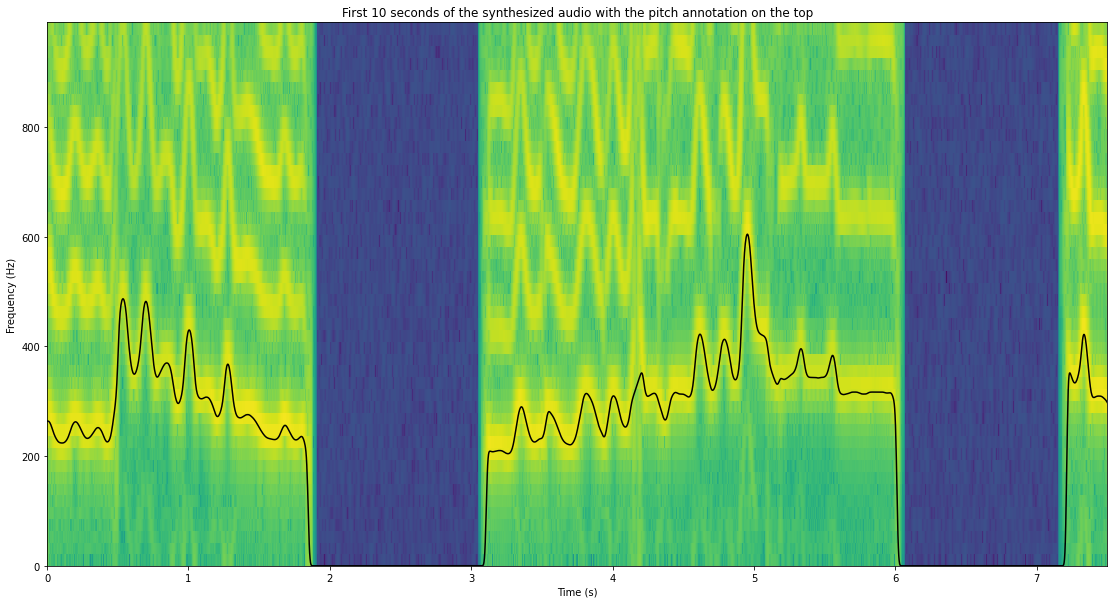

===> Listen to the synthesized track:


In [ ]:
# If you skip this line the plot doesn't work
%matplotlib inline 

import IPython.display as ipd
import shutil

from sms_tools.models import utilFunctions as UF
from sms_tools.models import harmonicModel as HM
from sms_tools.models import sineModel as SM
from sms_tools.models import stft
from sms_tools.models import dftModel as DFT

eps = np.finfo(float).eps

# Get synthesized audio and pitch track
track_to_generate = saraga_subset[2]  # Choose here the track to synthesize

track_duration = saraga_data[track_to_generate].metadata['length']
print('''
    Track duration in minutes: {}. Make sure you do not select a longer length to synthesize!
    '''.format(track_duration / 44100))

# Run the generation process
synthesized_audio, pitch_track, time_stamps = generate_track(
    filename=saraga_data[track_to_generate].audio_vocal_path,
    seconds=30,
    synth_parameters=parameters,
    pitch_preproc=True,
    voicing=True,
)

# Code for plotting the f0 contour on top of the spectrogram (taken from sms-tools)
maxplotfreq = 500.0
N = 2048
M = 2001
H = 128

plt.figure(figsize=(19, 10))
w  = get_window(parameters['window'], M)   
mX, pX = stft.stftAnal(synthesized_audio, w, N, H) 
mX = np.transpose(mX[:,:int(parameters['N']*(maxplotfreq/44100))+1])
    
#timeStamps = np.arange(mX.shape[1])*parameters['H']/float(44100)                             
binFreqs = np.arange(mX.shape[0])*44100/float(N)
    
plt.pcolormesh(time_stamps, binFreqs, mX)
plt.plot(time_stamps, pitch_track, color = 'k', linewidth=1.5)

plt.xlim([0, 7.5])
    
plt.title('First 7.5 seconds of the synthesized audio with the pitch annotation on the top')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.show()

# Play audio
print('===> Listen to the synthesized track:')
ipd.Audio(synthesized_audio, rate=44100)